# Capstone Part 4: Yearly Solar data
## By Elizabeth Tyree


### Problem Statement:
### Can the occurrence of sunspots be used to predict the frequency of earthquakes?

## Executive Summary: 
This project uses machine learning tools such as the ARMA, SARIMAX, and LSTM’s, to predict sunspots using yearly mean sunspot numbers from the Sunspot Index and Long-term Solar Observations (SILSO) data, Royal Observatory of Belgium, Brussels. The models are compared to each other for accuracy of prediction. The goal is to see if machine learning can help settle the debate on weather or not Sunspots and Earthquakes have any correlation with each other. 

This goal is approached in Three phases, however this capstone at the moment is only concerned with Phase 1. Here are the phases of this project and the overall importance to provide clarity with respect to the overarching context of this capstone. 

    -> Phase 1: Sunspot Modeling using ARMA, SARIMAX, and LSTM
    -> Phase 2: Earthquake Modeling using SARIMAX, and LSTM
    -> Phase 3: Earthquake Modeling and Prediction using Sunspots as a feature in SARIMAX and LSTM.

Importance: The ability to predict earthquakes or at least better understand them may lead to saving lives and reducing the impact of earthquakes through better preparedness. Within the scientific community there is a debate as to weather or not sunspots and earthquakes on earth are correlated. Usually this debate falls into one of two categories, 1) There is no correlation between sunspots and earthquakes. If you see a pattern, it’s not real. Or, 2) Sunspots and earthquakes may be correlated, more research needs to be done.  

Milestones and Key Metrics: 

    For Phase 1: Working ARMA, SARIMAX, and LSTM models. Using mean absolute error for validation.
    -> ARMA mean absolute error = 32.90
    -> SARIMAX mean absolute error = TBD
    -> LSTM mean absolute error = 0.22

Conclusions and Recommendations:  Out of all three models the LSTM performed the best with respect to mean absolute error. 

Next Steps: Phase 2



## Overall Capstone Outline

Part 1: Data Summary | Datasets in possession 

-> Yearly Mean Sunspot Numbers Source: WDC-SILSO, Royal Observatory of Belgium, Brussels.

    File Name: SN_y_tot_V2.0.txt
    Data Format: plain ASCII text
    Features: Frac_Year, Yearly_Mean_Sunspot_Number, Std, Number_of_observations, Definitive_provisional_indicator 
    Date Range: 1700 to 2017 
    Note: The file itself does not contain headers.


-> The Centennial catalog from the USGS, contains earthquakes from 1900 to 2007.

    File Name: Centennial_Y2K.cat
    Data Format: *.cat (csv)
    Features: icat, msc1, mdo1, yr, mon, Day, hr, Min, sec, glat, glon, dep, greg, ntel, mag1, Fract_Year
    Date Range: 01/01/1903 to 09/30/2007
    
-> Reviewed Earthquakes data from the USGS 1900-2016 all magnitudes.
    
    File Name: RevCatAllM_1900-2016_rev3.txt
    Data Format: csv
    Features: time, latitude, longitude, depth, mag, magType, nst, gap, dmin, rms, net, id, updated, place, type, 
    horizontalError, depthError, magError, magNst, status, locationSource, magSource
    Date Range: 1900-2016
    
-> International Seismological Centre (ISC) catalog of earthquakes from 1900 to 2016.

    Data Format: *.csv
    Features: 
    Date Range: 1900-2016
    
Part 2: Data Cleaning and Exploratory Data Analysis (EDA)

Part 3: Using Yearly Average Sunspot Numbers for Model 1: ARMA

Part 4: Using Yearly Average Sunspot Numbers for Model 2: SARIMAX

Part 5: Using Yearly Average Sunspot Numbers for Model 3: LSTM


In [1]:
# Importing Libraries

import numpy as np
np.random.seed(19680801)

import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ast
import datetime as dt
from datetime import timedelta
from datetime import datetime
import time
#from datetime import now

#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 # Use this at the command line to expand rate limit!
# or the function prep_posts may not work properly.
plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None) 
%matplotlib inline

## Data Cleaning and EDA

In [104]:
# Loading the Yearly mean sunspot data, these are the yearly mean sunspot numbers.
# Data dictionary that is copied and pasted below, can be found here: http://www.sidc.be/silso/infosndtot
# Sunspot data source: SILSO data, Royal Observatory of Belgium, Brussels.
'''
Time range: 1700 - last elapsed year

Data description:
Yearly mean total sunspot number obtained by taking a simple arithmetic mean of the daily total sunspot number over all days of each year. (NB: in early years in particular before 1749, the means are computed on only a fraction of the days in each year because on many days, no observation is available).

Error values:
The yearly standard deviation of individual data is derived from the daily values by the same formula as the monthly means:
sigma(m)=sqrt(SUM(N(d)*sigma(d)^2)/SUM(N(d)))
where sigma(d) is the standard deviation for a single day and N(d) is the
number of observations for that day.

The standard error on the yearly mean values can be computed by:
sigma/sqrt(N) where sigma is the listed standard deviation and N the total number of observations in the year.
NB: this standard error gives a measure of the precision, i.e. the sensitivity of the yearly value to different samples of daily values with random errors. The uncertainty on the mean (absolute accuracy) is only determined on longer time scales, and is thus not given here for individual yearly values.

-------------------------------------------------------------------------------
TXT
-------------------------------------------------------------------------------
Filename: SN_y_tot_V2.0.txt
Format: plain ASCII text

Contents:
Column 1: Gregorian calendar year (mid-year date)
Column 2: Yearly mean total sunspot number.
Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.
Column 4: Number of observations used to compute the yearly mean total sunspot number.
Column 5: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the yearly average still contains provisional daily values and is subject to a possible revision.

Line format [character position]:
- [1-6] Year (decimal)
- [9-13] Yearly mean total sunspot number
- [15-19] Standard deviation
- [22-26] Number of observations
- [28] Definitive/provisional indicator

-------------------------------------------------------------------------------
CSV
-------------------------------------------------------------------------------
Filename: SN_y_tot_V2.0.csv
Format: Comma Separated values (adapted for import in spreadsheets)
The separator is the semicolon ';'.

Contents:
Column 1: Gregorian calendar year (mid-year date)
Column 2: Yearly mean total sunspot number.
Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.
Column 4: Number of observations used to compute the yearly mean total sunspot number.
Column 5: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.
''';

# Headers for the sunspot data.
my_cols_y = ['Frac_Year','Yearly_Mean_Sunspot_Number','y_Std','Number_of_observations', 'Definitive_provisional_indicator'] # The file does not contain headers.

# Loading the data file
ISSN_Y_tot = pd.read_csv('./data/SN_y_tot_V2.0.csv',names=my_cols_y,sep=';', engine='python')

In [105]:
ISSN_Y_tot.head() # Checking that the data loaded properly by viewing the head.

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


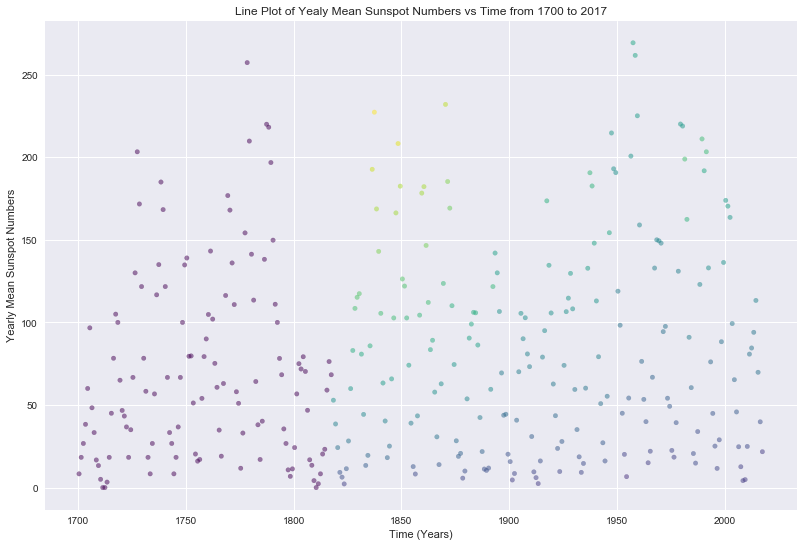

In [106]:
# REALLY Important!! Keep this Plot!


# https://matplotlib.org/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py
# https://www.robotswillkillusall.org/posts/mpl-scatterplot-colorbar.html

N = len(ISSN_Y_tot['Yearly_Mean_Sunspot_Number'])
x = ISSN_Y_tot['Frac_Year']
y = ISSN_Y_tot['Yearly_Mean_Sunspot_Number']
y_Std = ISSN_Y_tot['y_Std']
z = list([i for i in y_Std])
#z = list(sorted([i**3 for i in y]))


# cmap will generate a tuple of RGBA values for a given number in the range 0.0 to 1.0 
# (also 0 to 255 - not used in this example).
# To map our z values cleanly to this range, we create a Normalize object.
cmap = matplotlib.cm.get_cmap('viridis')
normalize = matplotlib.colors.Normalize(vmin=min(z), vmax=max(z))
colors = [cmap(normalize(value)) for value in z]


#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
area=20

fig, ax = plt.subplots()
ax.scatter(x, y, s=area, c=colors, alpha=0.5)


# Add title and axis names
plt.title('Line Plot of Yealy Mean Sunspot Numbers vs Time from 1700 to 2017')
plt.xlabel('Time (Years)') 
plt.ylabel('Yearly Mean Sunspot Numbers')
#plt.xlim(0,10)

# Show graphic
plt.show()

In [107]:
# Checking the min and max z for the plot above.
np.min(z)

-1.0

In [108]:
np.max(z)

19.1

In [109]:
ISSN_Y_tot.head() # Viewing the head of the sunspot data.

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [110]:
ISSN_Y_tot.tail() # Viewing the tail of the sunspot data

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
313,2013.5,94.0,6.9,5347,1
314,2014.5,113.3,8.0,5273,1
315,2015.5,69.8,6.4,8903,1
316,2016.5,39.8,3.9,9940,1
317,2017.5,21.7,2.5,11444,1


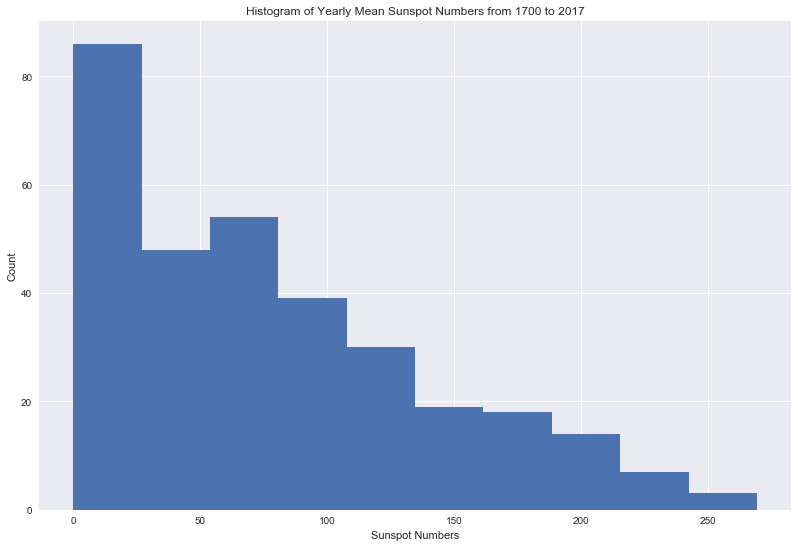

In [111]:
# Histogram of Yearly mean Sunspot Numbers from the ISSN.
#bin_size = 0.5
#n_bins = 10/bin_size


plt.hist(ISSN_Y_tot['Yearly_Mean_Sunspot_Number'])    
# Add title and axis names
plt.title('Histogram of Yearly Mean Sunspot Numbers from 1700 to 2017')
plt.xlabel('Sunspot Numbers') #Default is 10 bins
plt.ylabel('Count')
#plt.xlim(0,10)

# Show graphic
plt.show()

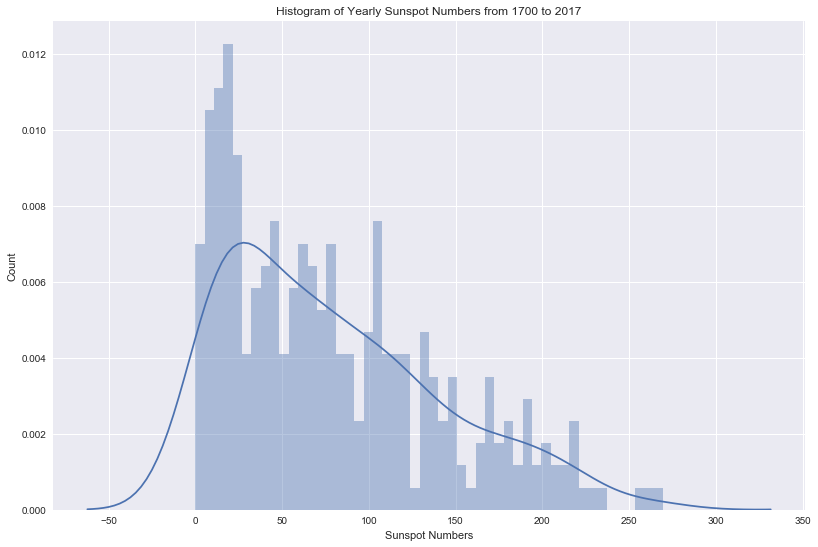

In [112]:
sns.set(rc={'figure.figsize':(12,9)})
f,ax = plt.subplots()
sns.distplot(ISSN_Y_tot['Yearly_Mean_Sunspot_Number'], bins=50, axlabel ='Sunspot Numbers')
ax.set_title('Histogram of Yearly Sunspot Numbers from 1700 to 2017')
ax.set_xlabel('Sunspot Numbers');
ax.set_ylabel('Count');

In [113]:
# Crosstab of Sunspot numbers.
pd.crosstab(index=ISSN_Y_tot['Yearly_Mean_Sunspot_Number'],  # Make a crosstab
                      columns="count")      # Name the count column

col_0,count
Yearly_Mean_Sunspot_Number,
0.0,3
2.2,1
2.3,1
2.4,1
3.3,1
4.2,2
4.6,1
4.8,1
5.0,1


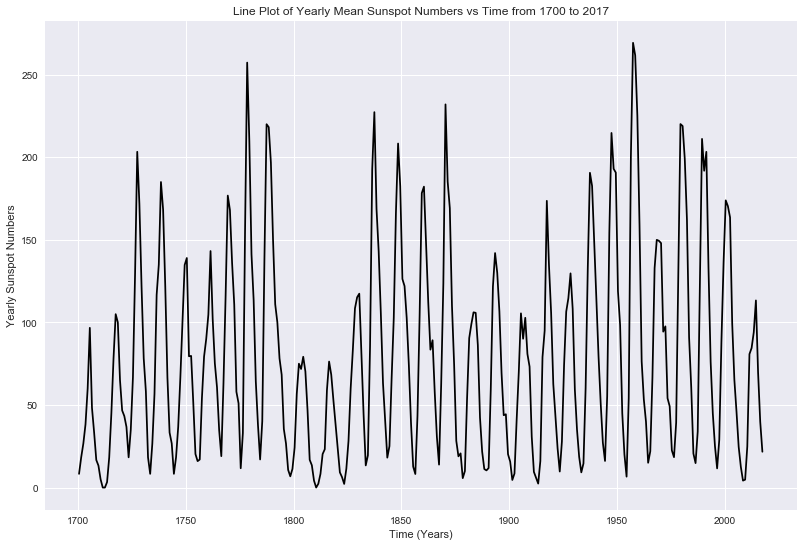

In [114]:
# Plotting the Sunspot numbers vs time in Years.
plt.plot(ISSN_Y_tot['Frac_Year'],ISSN_Y_tot['Yearly_Mean_Sunspot_Number'],'k-')

# Add title and axis names
plt.title('Line Plot of Yearly Mean Sunspot Numbers vs Time from 1700 to 2017')
plt.xlabel('Time (Years)') #Default is 10 bins
plt.ylabel('Yearly Sunspot Numbers')
#plt.xlim(0,10)

# Show graphic
plt.show()

## Using Yearly Average Sunspot Numbers for Model 1: ARMA.

In [115]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### Preparing to decompose the time stamp

In [116]:
ISSN_Y_tot.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [117]:
ISSN_Y_tot.tail()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
313,2013.5,94.0,6.9,5347,1
314,2014.5,113.3,8.0,5273,1
315,2015.5,69.8,6.4,8903,1
316,2016.5,39.8,3.9,9940,1
317,2017.5,21.7,2.5,11444,1


### Decomposing the Time stamp

In [118]:
yearly_sun = ISSN_Y_tot.copy() # Making a copy of the sunspot data.

# Creating a new Date feature
yearly_sun['Date'] = yearly_sun['Frac_Year'].astype(int) # Converting the fraction year to an integer.
yearly_sun['Date'] = pd.to_datetime(yearly_sun['Date'], format='%Y') # Converting data type to a timedate type.
delta_t = datetime(1701,1,1) - datetime(1700,1,1) # delta_t is 1 year.


yearly_sun['Date'] = yearly_sun.Date + delta_t # Adding delta_t to the date
yearly_sun.set_index('Date', inplace=True) # Setting the Date column as the index.


In [119]:
yearly_sun.head() # Viewing the head to see if the changes persisted.

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
Date,,,,,
1701-01-01,1700.5,8.3,-1.0,-1,1
1702-01-01,1701.5,18.3,-1.0,-1,1
1703-01-01,1702.5,26.7,-1.0,-1,1
1704-01-01,1703.5,38.3,-1.0,-1,1
1704-12-31,1704.5,60.0,-1.0,-1,1


In [120]:
yearly_sun.index # Verifying the Date is now a Datetime Index

DatetimeIndex(['1701-01-01', '1702-01-01', '1703-01-01', '1704-01-01',
               '1704-12-31', '1706-01-01', '1707-01-01', '1708-01-01',
               '1708-12-31', '1710-01-01',
               ...
               '2008-12-31', '2010-01-01', '2011-01-01', '2012-01-01',
               '2012-12-31', '2014-01-01', '2015-01-01', '2016-01-01',
               '2016-12-31', '2018-01-01'],
              dtype='datetime64[ns]', name='Date', length=318, freq=None)

In [121]:
# Setting the frequency to be yearly for the index.
yearly_sun.index = pd.date_range('1/1/1700', 
                          periods=len(yearly_sun.index),name='Date', freq='Y')

In [122]:
yearly_sun.index # Making sure the "freq=None" has changed to "freq='A-DEC'".

DatetimeIndex(['1700-12-31', '1701-12-31', '1702-12-31', '1703-12-31',
               '1704-12-31', '1705-12-31', '1706-12-31', '1707-12-31',
               '1708-12-31', '1709-12-31',
               ...
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=318, freq='A-DEC')

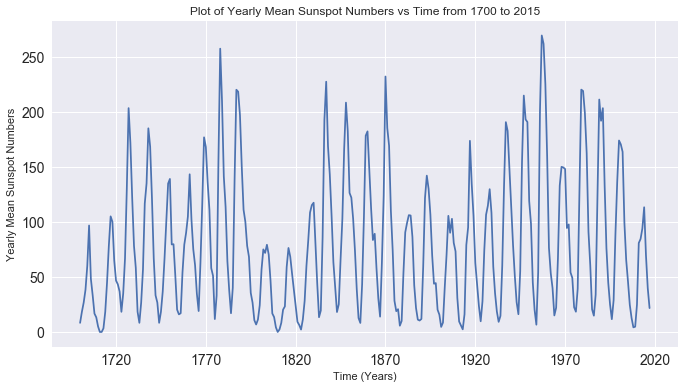

In [123]:
# Plotting the yearly mean sunspot numbers vs. time in Years.
yearly_sun.Yearly_Mean_Sunspot_Number.plot(figsize=(10,6), title= 'Plot of Yearly Mean Sunspot Numbers vs Time from 1700 to 2015', fontsize=14)
plt.xlabel('Time (Years)'); 
plt.ylabel('Yearly Mean Sunspot Numbers');

## Pre Model Staging: 
## Decomposing the Time Series data, looking at the plots for trends and seasonality 

In [124]:
yearly_sun.dtypes

Frac_Year                           float64
Yearly_Mean_Sunspot_Number          float64
y_Std                               float64
Number_of_observations                int64
Definitive_provisional_indicator      int64
dtype: object

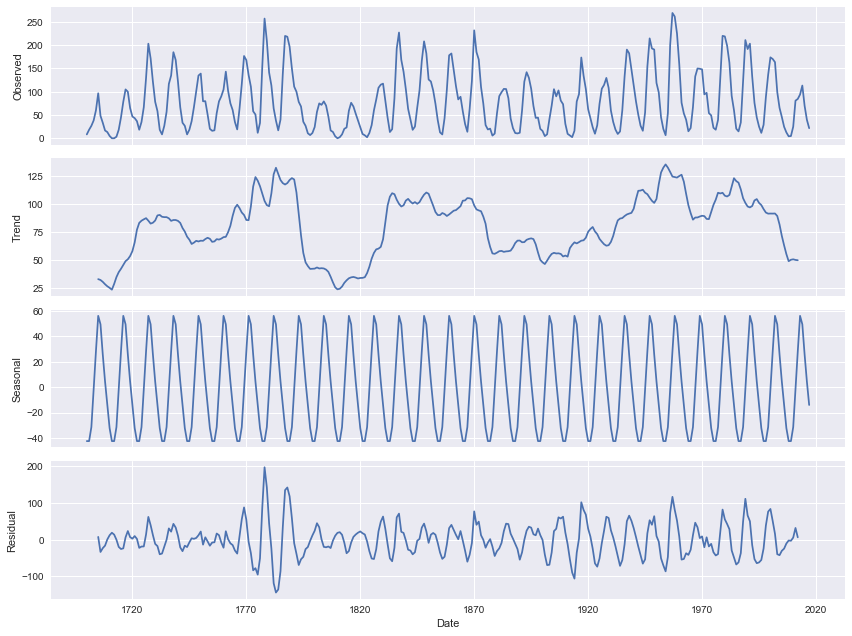

In [125]:
decomposition = seasonal_decompose(yearly_sun.Yearly_Mean_Sunspot_Number, freq=11)# You originally had 11 for one solar cycle.
decomposition.plot();

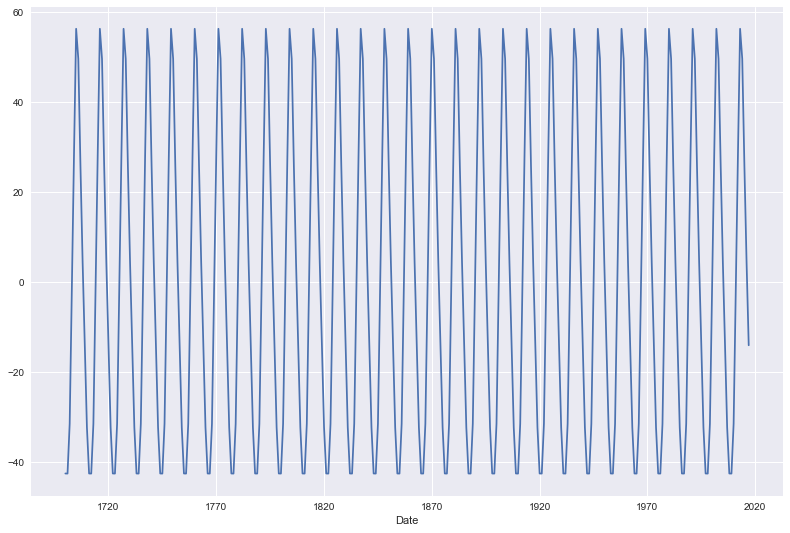

In [126]:
# Ploting only the seasonal componet
seasonal = decomposition.seasonal 
seasonal.plot()

## Utilizing the Dickey-Fuller test for stationartity of the data series.

In [127]:
# Define a Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=11, center=False).mean()
    rolstd = timeseries.rolling(window=11, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = timeseries.plot(color='blue',label='Original')
    mean = rolmean.plot(color='red', label='Rolling Mean')
    std = rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )


###### Perform the test.
test_stationarity(yearly_sun.Yearly_Sun_Spot_Number)

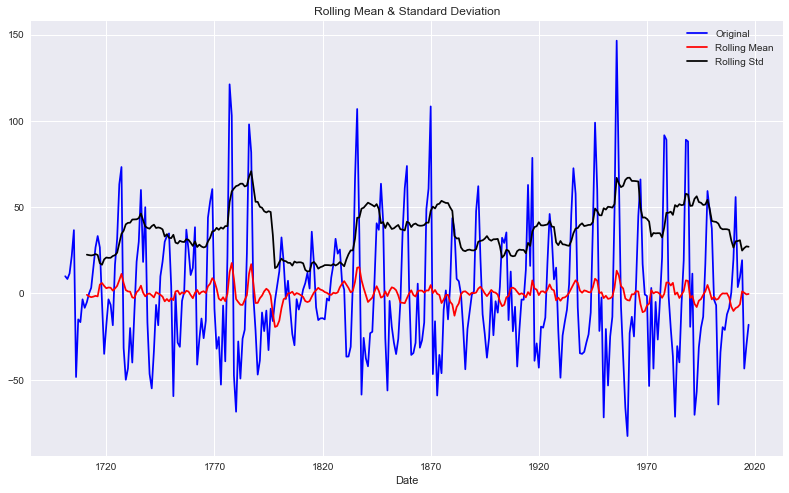

Results of Dickey-Fuller Test:
Test Statistic   -1.486027e+01
p-value           1.723470e-27
dtype: float64


In [128]:
# First difference:
yearly_sun['first_difference'] = yearly_sun.Yearly_Mean_Sunspot_Number.diff()
test_stationarity(yearly_sun.first_difference.dropna())

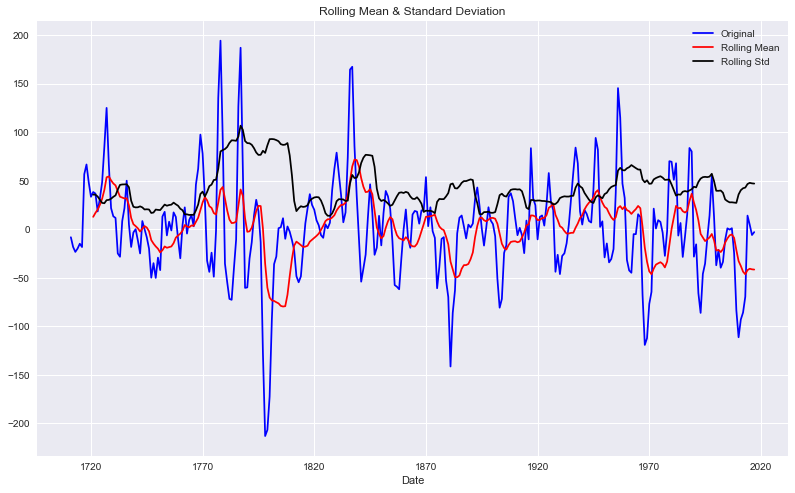

Results of Dickey-Fuller Test:
Test Statistic   -4.351080
p-value           0.000362
dtype: float64


In [129]:
# Seasonal difference:
yearly_sun['seasonal_difference'] = yearly_sun.Yearly_Mean_Sunspot_Number.diff(11)  
test_stationarity(yearly_sun.seasonal_difference.dropna())

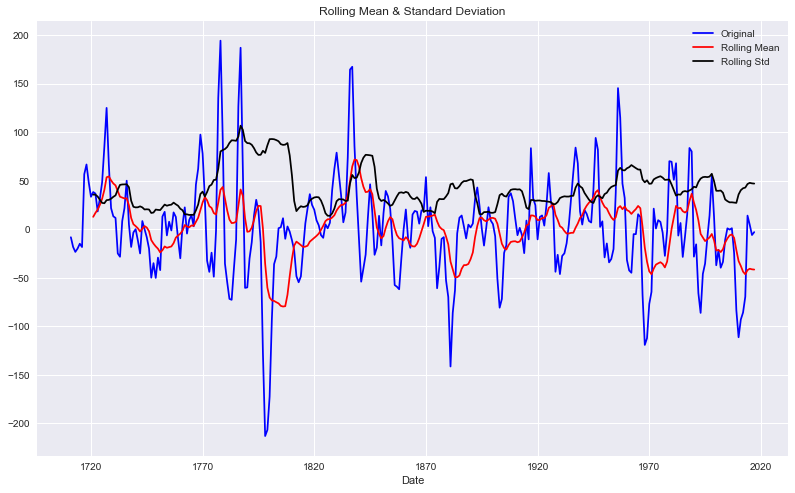

Results of Dickey-Fuller Test:
Test Statistic   -4.351080
p-value           0.000362
dtype: float64


In [130]:
# First seasonal difference:
yearly_sun['seasonal_first_difference'] = yearly_sun.Yearly_Mean_Sunspot_Number.diff(11)  
test_stationarity(yearly_sun.seasonal_first_difference.dropna())

## Training the ARMA Model

In [131]:
train_test = yearly_sun.copy()
train_test.dropna(inplace=True)

In [132]:
from statsmodels.tsa.arima_model import ARMA

train = train_test.head(290)
test = train_test.tail(17)

p = 1  # number of previous time points to use in the AR
q = 0  # MA parameter

model = ARMA(train.seasonal_first_difference, (p,q)).fit()
model.summary()

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     seasonal_first_difference   No. Observations:                  290
Model:                            ARMA(1, 0)   Log Likelihood               -1441.364
Method:                              css-mle   S.D. of innovations             34.811
Date:                       Sat, 14 Jul 2018   AIC                           2888.729
Time:                               12:51:40   BIC                           2899.738
Sample:                           12-31-1711   HQIC                          2893.140
                                - 12-31-2000                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.0941      7.766      0.270      0.788     -13.128      17.316
ar.L1.seasonal_first_difference     0.7393      0.039     18.839      0.000       0.662       0.816
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3526           +0.0000j            1.3526            0.0000
-----------------------------------------------------------------------------
"""

In [133]:
len(test)

17

In [134]:
train.tail(2)

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
1999-12-31,1999.5,136.3,9.3,6413,1,48.0,13.3,13.3
2000-12-31,2000.5,173.9,10.1,5953,1,37.6,-37.2,-37.2


In [135]:
test.head(2)

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
2001-12-31,2001.5,170.4,10.5,6558,1,-3.5,-21.4,-21.4
2002-12-31,2002.5,163.6,9.8,6588,1,-6.8,-39.7,-39.7


In [136]:
#test.reset_index(inplace=True)
test.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
2001-12-31,2001.5,170.4,10.5,6558,1,-3.5,-21.4,-21.4
2002-12-31,2002.5,163.6,9.8,6588,1,-6.8,-39.7,-39.7
2003-12-31,2003.5,99.3,7.1,7087,1,-64.3,-33.7,-33.7
2004-12-31,2004.5,65.3,5.9,6882,1,-34.0,-10.8,-10.8
2005-12-31,2005.5,45.8,4.7,7084,1,-19.5,0.9,0.9


In [137]:
#test['Date'] = test.Date + delta_t
#test.set_index('Date', inplace=True)
#test.head()

In [138]:
start = test.index[0].to_pydatetime()
start

datetime.datetime(2001, 12, 31, 0, 0)

In [139]:
end = test.index[-1].to_pydatetime()
end

datetime.datetime(2017, 12, 31, 0, 0)

In [140]:
test.index


DatetimeIndex(['2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31',
               '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31',
               '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31'],
              dtype='datetime64[ns]', name='Date', freq='A-DEC')

In [141]:
#test.index = pd.date_range(start='12/31/2004', periods=len(test.index),name='Date', freq='Y',normalize=False)
#test.index = pd.date_range(start='12/31/2004', periods=14,name='Date', freq='Y',normalize=False, )

In [142]:
test.index

DatetimeIndex(['2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31',
               '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31',
               '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31'],
              dtype='datetime64[ns]', name='Date', freq='A-DEC')

In [143]:
predictions_oos = model.predict(start=start, end=end, dynamic=True)
#predictions_oos = model.predict(start=start, end=end, dynamic=True)

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [144]:
len(test)

17

In [145]:
start = test.index[0].to_pydatetime()
end = test.index[-1].to_pydatetime()

#start = len(train) - 1
#end = start + len(test) - 1

predictions_oos = model.predict(start=start, end=end)
truth = test.seasonal_first_difference
model.forecast()

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


(array([-26.95648546]),
 array([34.81052174]),
 array([[-95.18385436,  41.27088344]]))

In [146]:
truth = test.seasonal_first_difference


In [147]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(truth, predictions_oos))

32.90943629424748


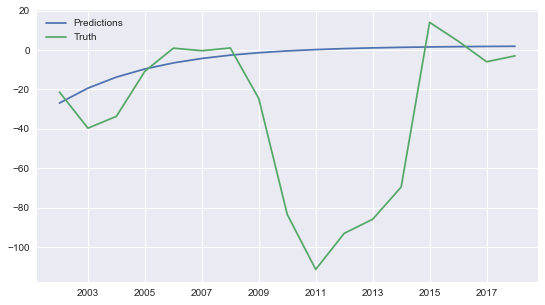

In [148]:
plt.subplots(figsize=(8,5))
plt.plot(truth.index, predictions_oos, label='Predictions')
plt.plot(truth.index, truth.values, label='Truth')
plt.legend()

In [151]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: ARMA
===============================================================================
Model:                ARMA                      BIC:                 2899.7384 
Dependent Variable:   seasonal_first_difference Log-Likelihood:      -1441.4   
Date:                 2018-07-14 12:53          Scale:               1.0000    
No. Observations:     290                       Method:              css-mle   
Df Model:             2                         Sample:              12-31-1711
Df Residuals:         288                                            12-31-2000
Converged:            1.0000                    S.D. of innovations: 34.811    
AIC:                  2888.7287                 HQIC:                2893.140  
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-------------------------------------------------------------------------------
const                           2.0941   7.7664  0.2696 0.7876 -13.1277 17.3160
ar.L1.seasonal_first_difference 0.7393   0.0392 18.8387 0.0000   0.6624  0.8162
--------------------------------------------------------------------------------------------
                    Real               Imaginary              Modulus              Frequency
--------------------------------------------------------------------------------------------
AR.1               1.3526                 0.0000               1.3526                 0.0000
===============================================================================

"""

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


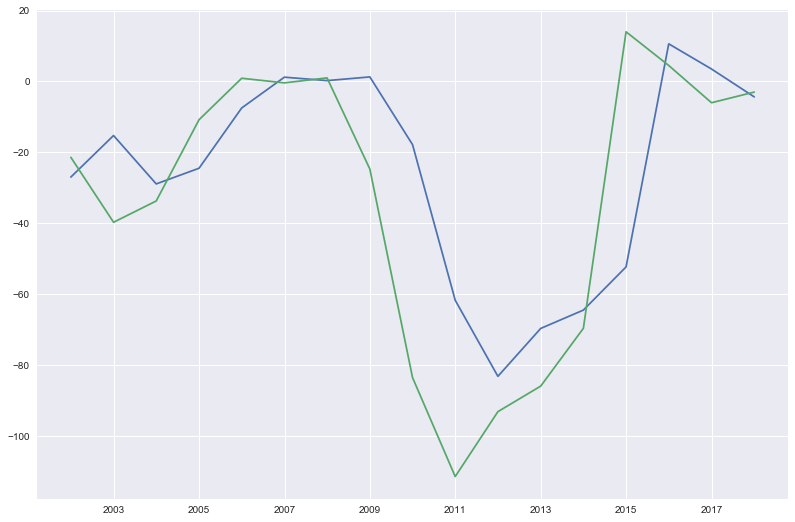

In [47]:
predictions_rolling = []
training_observations = list(train.seasonal_first_difference.values)
testing_observations = test.seasonal_first_difference.values

for obs in testing_observations:
    model_roll = ARMA(training_observations, (1,0)).fit(disp=0)
    predictions_rolling.append(model_roll.forecast()[0][0])
    training_observations.append(obs)
    
plt.plot(test.index, predictions_rolling, label='Fitted')
plt.plot(test.index, testing_observations, label='Truth')

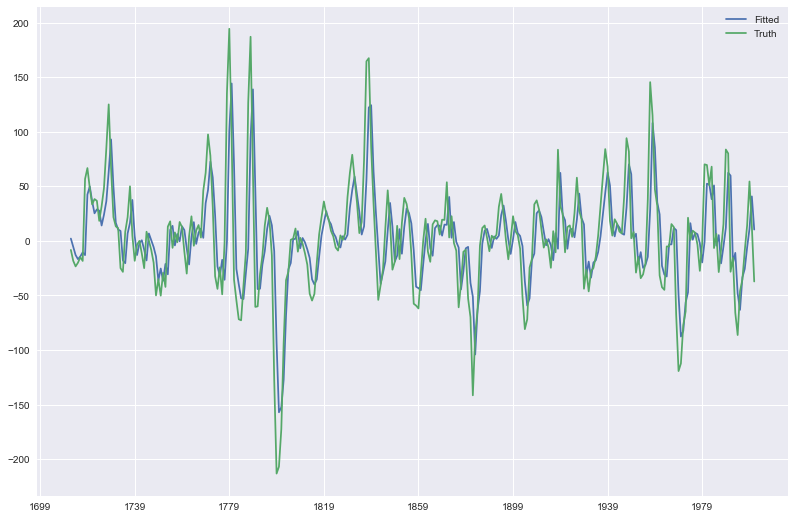

In [48]:
plt.plot(train.index, model.fittedvalues, label='Fitted')
plt.plot(train.index, train.seasonal_first_difference.values, label='Truth')
plt.legend()

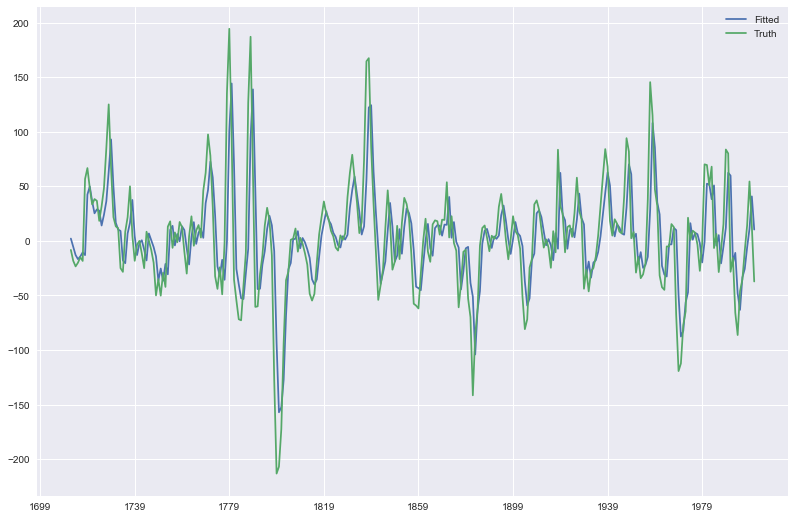

In [49]:
plt.plot(train.index, model.fittedvalues, label='Fitted')
plt.plot(train.index, train.seasonal_first_difference.values, label='Truth')
plt.legend()

In [50]:
model. # You wanted to ask Justin how to transform values back to sunspot numbers for the ARMA. 
# Or are they already sunspot numbers?


SyntaxError: invalid syntax (<ipython-input-50-e5b77b04f37d>, line 1)

In [ ]:
plot_acf(train.seasonal_first_difference.values,lags=50);

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

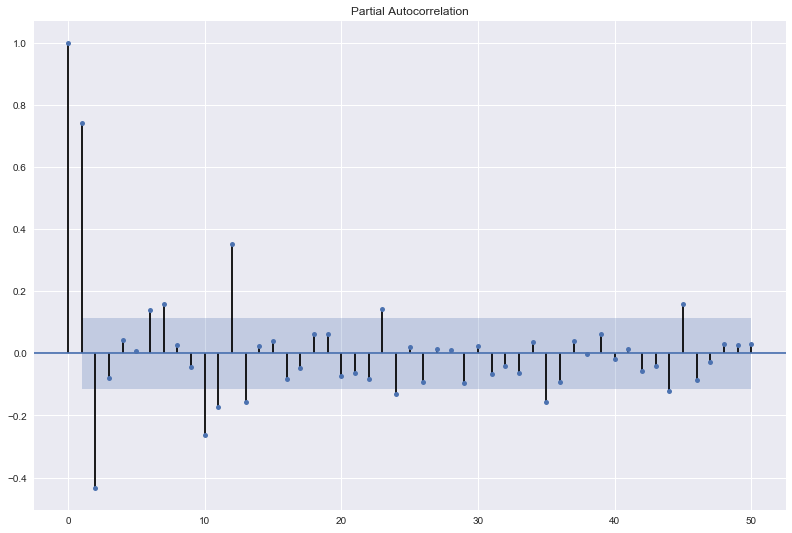

In [51]:
plot_pacf(train.seasonal_first_difference.values, lags=50);

In [52]:
test.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
2001-12-31,2001.5,170.4,10.5,6558,1,-3.5,-21.4,-21.4
2002-12-31,2002.5,163.6,9.8,6588,1,-6.8,-39.7,-39.7
2003-12-31,2003.5,99.3,7.1,7087,1,-64.3,-33.7,-33.7
2004-12-31,2004.5,65.3,5.9,6882,1,-34.0,-10.8,-10.8
2005-12-31,2005.5,45.8,4.7,7084,1,-19.5,0.9,0.9


In [53]:
predictions_oos

2001-12-31   -26.956485
2002-12-31   -19.383333
2003-12-31   -13.784411
2004-12-31    -9.645061
2005-12-31    -6.584790
2006-12-31    -4.322295
2007-12-31    -2.649606
2008-12-31    -1.412966
2009-12-31    -0.498704
2010-12-31     0.177221
2011-12-31     0.676940
2012-12-31     1.046389
2013-12-31     1.319526
2014-12-31     1.521460
2015-12-31     1.670753
2016-12-31     1.781126
2017-12-31     1.862727
Freq: A-DEC, dtype: float64

In [54]:
predictions = model.predict()

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [55]:
len(predictions)

290

In [56]:
 len(yearly_sun.Yearly_Mean_Sunspot_Number) - len(predictions)

28

In [57]:
yearly_sun.index

DatetimeIndex(['1700-12-31', '1701-12-31', '1702-12-31', '1703-12-31',
               '1704-12-31', '1705-12-31', '1706-12-31', '1707-12-31',
               '1708-12-31', '1709-12-31',
               ...
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=318, freq='A-DEC')

In [58]:
yearly_sun.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
1700-12-31,1700.5,8.3,-1.0,-1,1,NaN,NaN,NaN
1701-12-31,1701.5,18.3,-1.0,-1,1,10.0,NaN,NaN
1702-12-31,1702.5,26.7,-1.0,-1,1,8.4,NaN,NaN
1703-12-31,1703.5,38.3,-1.0,-1,1,11.6,NaN,NaN
1704-12-31,1704.5,60.0,-1.0,-1,1,21.7,NaN,NaN


/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


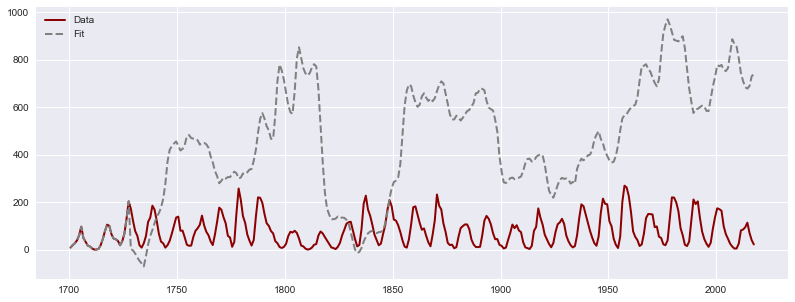

In [59]:
predictions = model.predict() # This is the prediction of the full data anfter undoing the first diff.
full_pred = pd.concat([yearly_sun.Yearly_Mean_Sunspot_Number[0:28], pd.DataFrame(np.cumsum(predictions))], axis=0)
#full_pred = yearly_sun.Yearly_Mean_Sunspot_Number.values[0:28] + np.cumsum(predictions)
#date_ticks = yearly_sun.index.to_timestamp()
date_ticks = yearly_sun.Frac_Year

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(date_ticks, yearly_sun.Yearly_Mean_Sunspot_Number, lw=2, color='darkred', label='Data')
ax.plot(date_ticks, full_pred, lw=2, color='grey', ls='dashed', label='Fit')
plt.legend()

#fig, ax = plt.subplots(figsize=(12,5))
#ax.plot(date_ticks[1:], udiff, lw=2, color='darkred',label='Data')
#ax.plot(date_ticks[1:], predictions, lw=2, color='grey', ls='dashed',label='Fit')
#plt.legend()
plt.show()

In [60]:
315-290

25

In [61]:
yearly_sun.Yearly_Mean_Sunspot_Number.values[0]

8.3

In [62]:
yearly_sun.Yearly_Mean_Sunspot_Number

Date
1700-12-31      8.3
1701-12-31     18.3
1702-12-31     26.7
1703-12-31     38.3
1704-12-31     60.0
1705-12-31     96.7
1706-12-31     48.3
1707-12-31     33.3
1708-12-31     16.7
1709-12-31     13.3
1710-12-31      5.0
1711-12-31      0.0
1712-12-31      0.0
1713-12-31      3.3
1714-12-31     18.3
1715-12-31     45.0
1716-12-31     78.3
1717-12-31    105.0
1718-12-31    100.0
1719-12-31     65.0
1720-12-31     46.7
1721-12-31     43.3
1722-12-31     36.7
1723-12-31     18.3
1724-12-31     35.0
1725-12-31     66.7
1726-12-31    130.0
1727-12-31    203.3
1728-12-31    171.7
1729-12-31    121.7
              ...  
1988-12-31    123.0
1989-12-31    211.1
1990-12-31    191.8
1991-12-31    203.3
1992-12-31    133.0
1993-12-31     76.1
1994-12-31     44.9
1995-12-31     25.1
1996-12-31     11.6
1997-12-31     28.9
1998-12-31     88.3
1999-12-31    136.3
2000-12-31    173.9
2001-12-31    170.4
2002-12-31    163.6
2003-12-31     99.3
2004-12-31     65.3
2005-12-31     45.8
2006-12-31     

In [63]:
yearly_sun.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
1700-12-31,1700.5,8.3,-1.0,-1,1,NaN,NaN,NaN
1701-12-31,1701.5,18.3,-1.0,-1,1,10.0,NaN,NaN
1702-12-31,1702.5,26.7,-1.0,-1,1,8.4,NaN,NaN
1703-12-31,1703.5,38.3,-1.0,-1,1,11.6,NaN,NaN
1704-12-31,1704.5,60.0,-1.0,-1,1,21.7,NaN,NaN


## Using Yearly Average Sunspot Numbers for Model 2: SARIMAX

In [64]:
sari_sun = ISSN_Y_tot.copy()

#yearly_sun['Frac_Year'] = pd.to_datetime(yearly_sun['Frac_Year'])
sari_sun['Date'] = sari_sun['Frac_Year'].astype(int)
sari_sun['Date'] = pd.to_datetime(sari_sun['Date'], format='%Y')
delta_t = datetime(1701,1,1) - datetime(1700,1,1)

sari_sun['Date'] = sari_sun.Date + delta_t
sari_sun.set_index('Date', inplace=True)

In [65]:
sari_sun.dtypes

Frac_Year                           float64
Yearly_Mean_Sunspot_Number          float64
y_Std                               float64
Number_of_observations                int64
Definitive_provisional_indicator      int64
dtype: object

In [66]:
sari_sun.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
Date,,,,,
1701-01-01,1700.5,8.3,-1.0,-1,1
1702-01-01,1701.5,18.3,-1.0,-1,1
1703-01-01,1702.5,26.7,-1.0,-1,1
1704-01-01,1703.5,38.3,-1.0,-1,1
1704-12-31,1704.5,60.0,-1.0,-1,1


## Decompose the Time Series for the SARIMAX and Plot

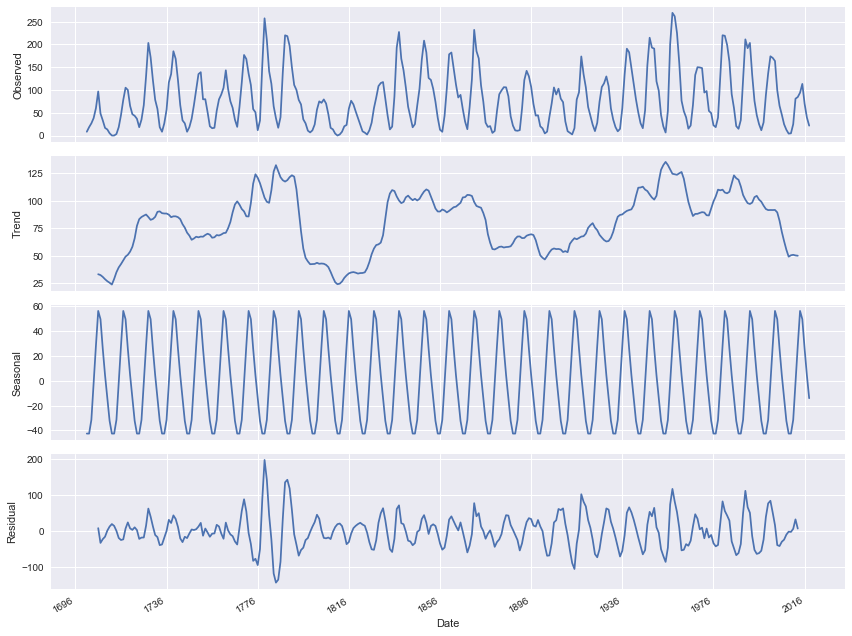

In [67]:
decomposition = seasonal_decompose(sari_sun.Yearly_Mean_Sunspot_Number, freq=11)# You originally had 11 for one solar cycle.
decomposition.plot();

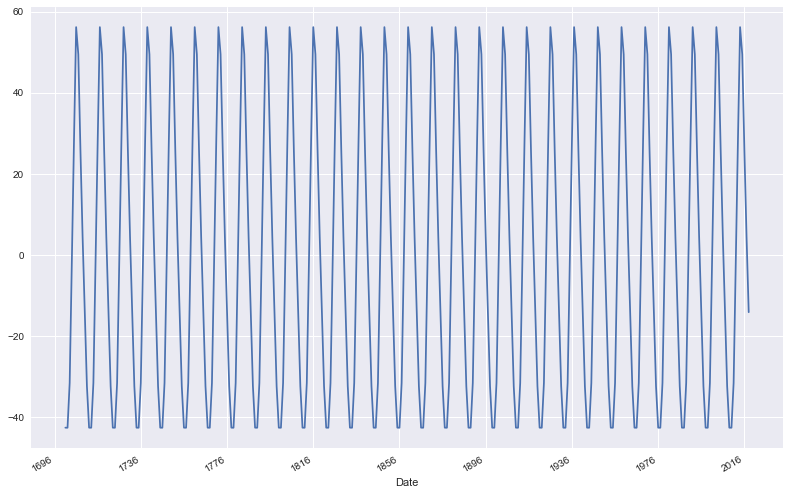

In [68]:
# Ploting only the seasonal componet
seasonal = decomposition.seasonal 
seasonal.plot()

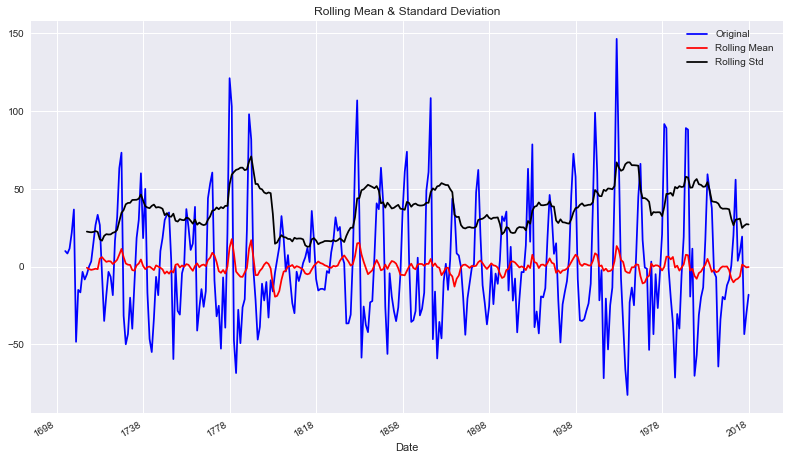

Results of Dickey-Fuller Test:
Test Statistic   -1.486027e+01
p-value           1.723470e-27
dtype: float64


In [69]:
# First difference:
sari_sun['first_difference'] = sari_sun.Yearly_Mean_Sunspot_Number.diff()
test_stationarity(sari_sun.first_difference.dropna())

In [70]:
import statsmodels.api as sm
# Grid search by setting up your own loop. No need to use the gridsearch function.
p = 1
d = 1 #Notes: do a manual diff of 1 year. (You do not need to give your manual diff to sarimax, just us it to determine seasonality using pacf.)
q = 1

P = 1
D = 1 # D is 11 years
Q = 0
s = 11 # You are chooing the season order

data = yearly_sun[['Yearly_Mean_Sunspot_Number']].stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  318
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 11)   Log Likelihood               -1499.283
Date:                            Sat, 14 Jul 2018   AIC                           3006.566
Time:                                    10:24:52   BIC                           3021.614
Sample:                                         0   HQIC                          3012.576
                                            - 318                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1640      0.131      1.249      0.212      -0.093       0.421
ma.L1          0.1837      0.128   

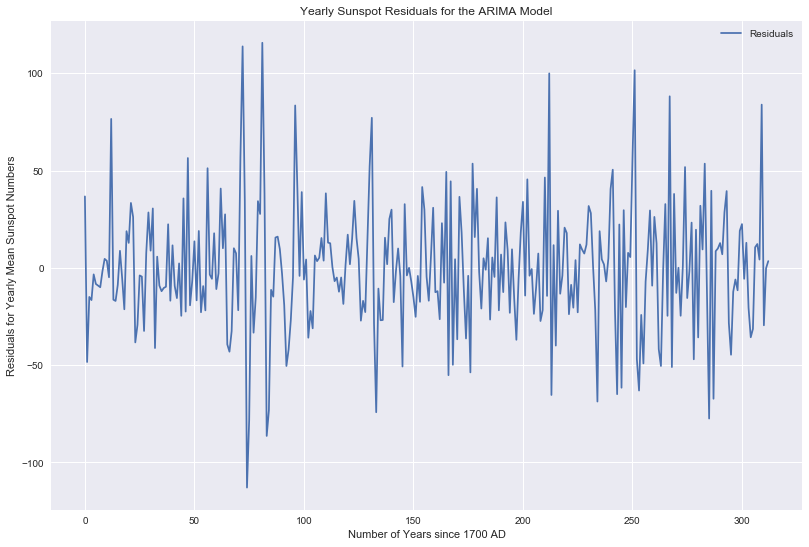

In [71]:
#Plot the residuals of the SARIMAX model.
# Don't plot the first five values to account for data loss when differencing (d=1 + D=5).
residuals = results.resid[5:]
plt.plot(residuals, label='Residuals')
plt.title('Yearly Sunspot Residuals for the ARIMA Model')
plt.ylabel('Residuals for Yearly Mean Sunspot Numbers') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.legend()
plt.show()

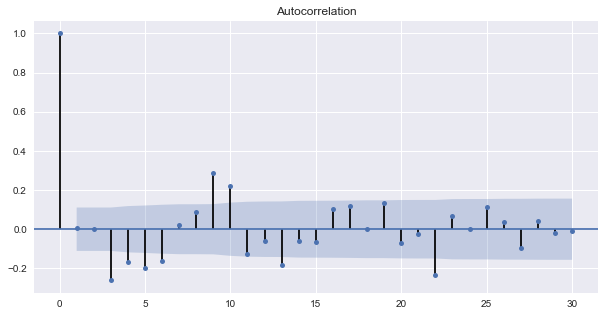

In [72]:
# Plot the ACF and PACF of the residuals.
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

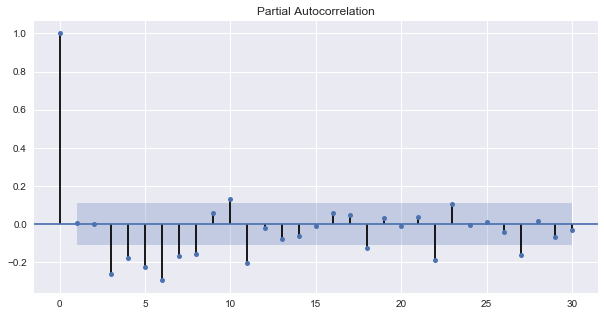

In [73]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

In [74]:
# From the Previous SARIMAX Model.
p = 0
d = 1
q = 1

P = 0
D = 1
Q = 1
s = 11 # You are choosing the season order
                                              #p,d,q                   P,D,Q,s
model = sm.tsa.statespace.SARIMAX(data, order=(1,1,1), seasonal_order=(0,1,1,11))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  318
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 11)   Log Likelihood               -1477.027
Date:                            Sat, 14 Jul 2018   AIC                           2962.054
Time:                                    10:24:54   BIC                           2977.102
Sample:                                         0   HQIC                          2968.064
                                            - 318                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2853      0.086      3.308      0.001       0.116       0.454
ma.L1          0.1862      0.091   

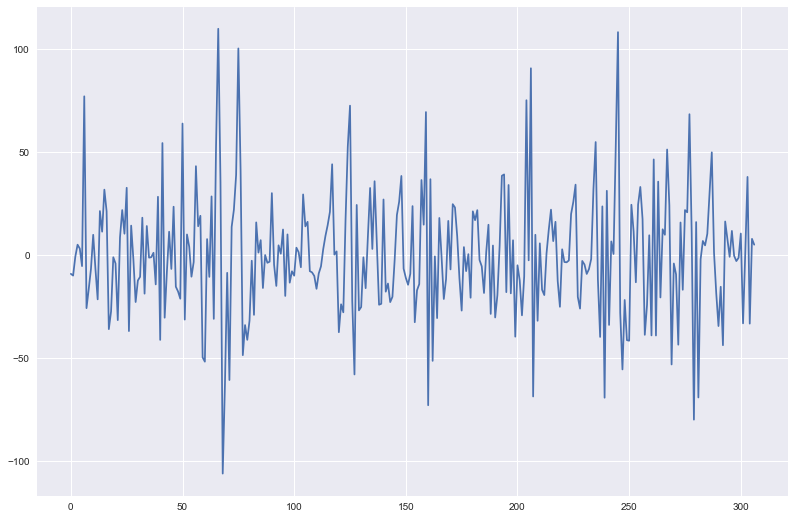

In [75]:
# Don't plot the first five values to account for data loss when differencing (d=1 + D=5).
residuals = results.resid[11:]
plt.plot(residuals)

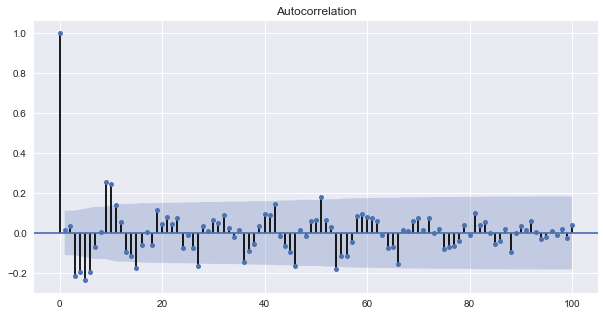

In [76]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=100, ax=ax)
plt.show()

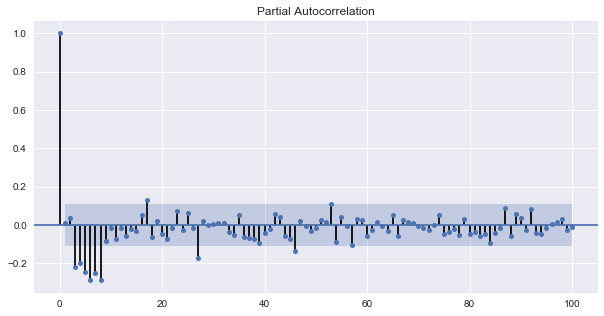

In [77]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=100, ax=ax)
plt.show()

In [78]:
# From the Previous Model 2 SARIMAX Model.
p = 0
d = 1
q = 1

P = 0
D = 1
Q = 1
s = 11 # You are choosing the season order
# You will need exog when adding another feater to the sarimax model. Use this after creating eq sarimax to add sunspots to eq model.
                                              #p,d,q                   P,D,Q,s
model = sm.tsa.statespace.SARIMAX(data, order=(1,1,1), seasonal_order=(0,1,1,11))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  318
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 11)   Log Likelihood               -1477.027
Date:                            Sat, 14 Jul 2018   AIC                           2962.054
Time:                                    10:24:56   BIC                           2977.102
Sample:                                         0   HQIC                          2968.064
                                            - 318                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2853      0.086      3.308      0.001       0.116       0.454
ma.L1          0.1862      0.091   

In [79]:
yearly_sun.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
1700-12-31,1700.5,8.3,-1.0,-1,1,NaN,NaN,NaN
1701-12-31,1701.5,18.3,-1.0,-1,1,10.0,NaN,NaN
1702-12-31,1702.5,26.7,-1.0,-1,1,8.4,NaN,NaN
1703-12-31,1703.5,38.3,-1.0,-1,1,11.6,NaN,NaN
1704-12-31,1704.5,60.0,-1.0,-1,1,21.7,NaN,NaN


## Using Yearly Average Sunspot Numbers for Model 3: LSTM

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [81]:
# Normalize the differenced first_difference sunspot data with MinMaxScaler
# The rate to be restricted to the range -1 to 1.
sunny = sari_sun[['first_difference']].iloc[1:, :]

mms = MinMaxScaler(feature_range=(-1, 1))
sunny = mms.fit_transform(sunny)

print(sunny.shape)


(317, 1)


In [82]:
train_size = len(sunny) - 25
test_size = len(sunny) - train_size
print(len(sunny), train_size, test_size)

train_lstm, test_lstm = sunny[0:train_size,:], sunny[train_size:len(sunny),:]

317 292 25


In [83]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
        
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[:-1, :]
    
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [84]:
X, y = create_data(sunny[:8], lag=3, as_array=False)

In [85]:
X

,lag1,lag2,lag3
0,-0.177652,-0.205587,-0.191619
1,-0.089481,-0.177652,-0.205587
2,0.041467,-0.089481,-0.177652
3,-0.701440,0.041467,-0.089481
4,-0.409865,-0.701440,0.041467


In [86]:
# Create training and testing data for a lag of 1
# This means  X will just have 1 column.

lag = 1
train_X, train_Y = create_data(train_lstm, lag)
test_X, test_Y = create_data(test_lstm, lag)

## Reshape the data to work with the LSTM
---

The format of data the LSTM expects is:

    [samples, time_steps, features]
    
where

- `samples`: number of observations,
- `time_steps`: number of (lagged) time steps to use in the prediction,
- `features`: number of features/sequences to use in the prediction.
    
This is a 3D matrix.

We have been using 2D predictor matrices for our machine learning algorithms, where our X predictor matrix has been in the form:

    [samples, features]

Since we are working with timeseries (which is the data an LSTM expects), we are now required to provide information about the time.

You can use the `np.reshape()` command to turn your 2D X matrix into a 3D matrix that works for the LSTM matrix. We will talk about the "time step" dimension more down the line. 

> **Note:** In the case of a single lag this time step dimension is redundant. Later on, when we redesign the X matrix so that our individual features have multiple timesteps, this 3D format requirement will be clearer.

In [87]:
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [88]:
print(train_X.shape, train_Y.shape)

(291, 1, 1) (291,)


In [89]:
# Model
np.random.seed(42)

batch_size = 1
model = Sequential()
model.add(LSTM(4, 
               batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), 
               stateful=True))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(20):
    model.fit(train_X, train_Y, validation_data=(test_X, test_Y), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 2s 6ms/step - loss: 0.1200 - val_loss: 0.0711
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 1s 5ms/step - loss: 0.1117 - val_loss: 0.0674
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 2s 6ms/step - loss: 0.1073 - val_loss: 0.0635
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 1s 5ms/step - loss: 0.1028 - val_loss: 0.0614
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 1s 5ms/step - loss: 0.1002 - val_loss: 0.0621
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 1s 4ms/step - loss: 0.0977 - val_loss: 0.0601
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 2s 6ms/step - loss: 0.0906 - val_loss:

MAE =  0.1715174883757983


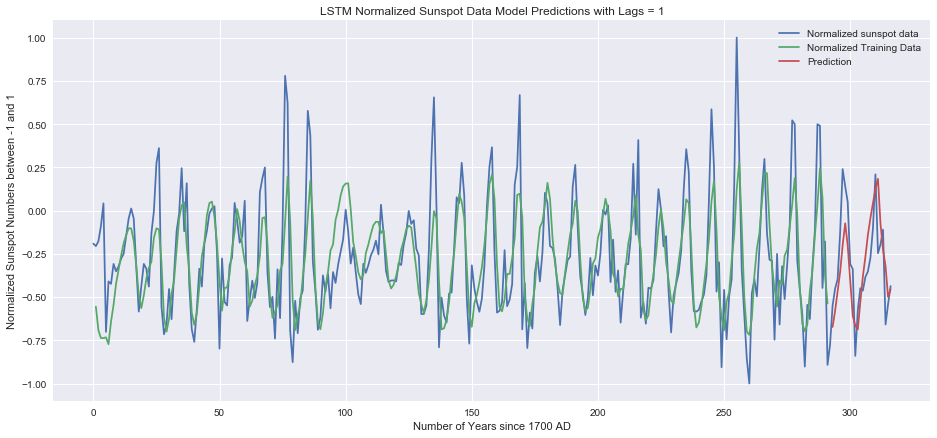

In [91]:
from sklearn.metrics import mean_absolute_error

train_predict = model.predict(train_X, batch_size=batch_size)
test_predict = model.predict(test_X, batch_size=batch_size)
test_observed = sunny[-len(test_predict):, :]

print('MAE = ', mean_absolute_error(test_observed, test_predict))

# shift train predictions for plotting
train_predict_plot = np.empty_like(sunny)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(sunny)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_predict):, :] = test_predict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(sunny, label='Normalized sunspot data')
plt.plot(train_predict_plot, label='Normalized Training Data')
plt.plot(test_predict_plot, label='Prediction')
plt.title('LSTM Normalized Sunspot Data Model Predictions with Lags = 1')
plt.ylabel('Normalized Sunspot Numbers between -1 and 1') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.legend()
plt.show()

In [92]:
y_jmp = pd.Series(np.array([1,2,3,4,5,6,7,8,9,10]))
y_jmp_diff = y_jmp.diff().dropna()

undo_diff = []
undo_diff.append(y_jmp[0])
for val in y_jmp_diff:
    undo_diff.append(val + undo_diff[-1])
    
undo_diff

[1, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

## LSTM with multiple lags as predictors


## LSTM with lags = 1 as predictors, tweaking the other params

In [93]:
lag = 1
train_X, train_Y = create_data(train_lstm, lag)
test_X, test_Y = create_data(test_lstm, lag)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

print(train_X[0:5])

[[[-0.19161938]]

 [[-0.20558708]]

 [[-0.17765168]]

 [[-0.08948058]]

 [[ 0.04146661]]]


In [94]:
np.random.seed(42)

batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, 1, lag), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [95]:
for i in range(20):
    model.fit(train_X, train_Y, validation_data=(test_X, test_Y), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 1s 5ms/step - loss: 0.1180 - val_loss: 0.0682
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 2s 6ms/step - loss: 0.1076 - val_loss: 0.0643
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 2s 7ms/step - loss: 0.1031 - val_loss: 0.0608
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 2s 6ms/step - loss: 0.0988 - val_loss: 0.0596
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 1s 5ms/step - loss: 0.0948 - val_loss: 0.0561
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 1s 5ms/step - loss: 0.0860 - val_loss: 0.0511
Train on 291 samples, validate on 24 samples
Epoch 1/1
291/291 [==============================] - 1s 5ms/step - loss: 0.0725 - val_loss:

MAE =  0.16237993245351143


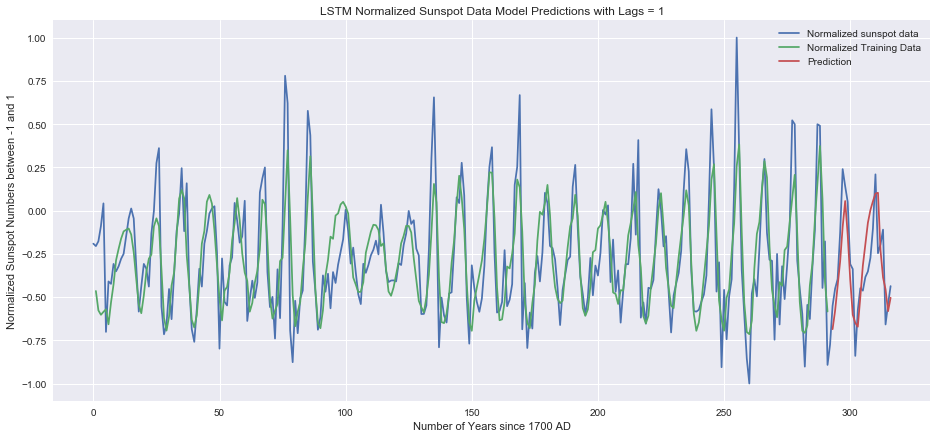

In [96]:
from sklearn.metrics import mean_absolute_error

model.reset_states()
train_predict = model.predict(train_X, batch_size=batch_size)
test_predict = model.predict(test_X, batch_size=batch_size)
test_observed = sunny[-len(test_predict):, :]

print('MAE = ', mean_absolute_error(test_observed, test_predict))

# shift train predictions for plotting
train_predict_plot = np.empty_like(sunny)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(sunny)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_predict):, :] = test_predict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(sunny, label='Normalized sunspot data')
plt.plot(train_predict_plot, label='Normalized Training Data')
plt.plot(test_predict_plot, label='Prediction')
plt.title('LSTM Normalized Sunspot Data Model Predictions with Lags = 1')
plt.ylabel('Normalized Sunspot Numbers between -1 and 1') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.legend()
plt.show()

MAE =  0.16237993245351143


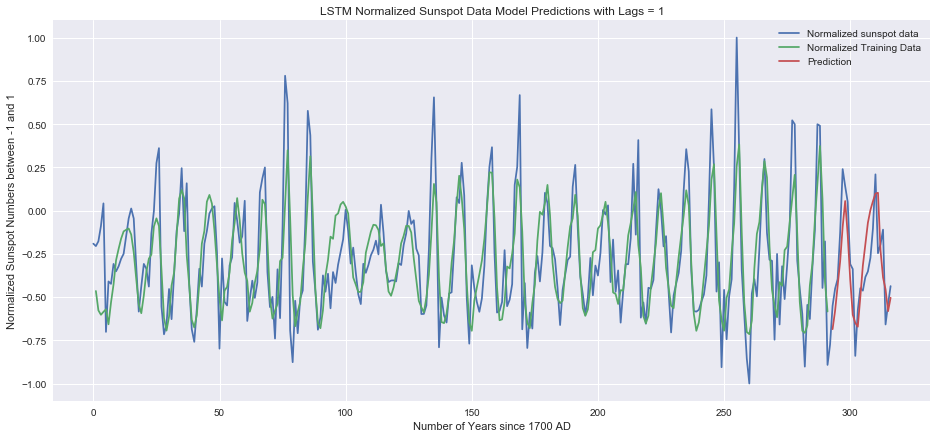

In [97]:
# ASK Justin about converting back to sunspot numbers. He told you already but you lost your notes!
#model.reset_states()
#train_predict = model.predict(train_X, batch_size=batch_size)
#test_predict = model.predict(test_X, batch_size=batch_size)
#test_observed = sunny[-len(test_predict):, :]

print('MAE = ', mean_absolute_error(test_observed, test_predict))

# shift train predictions for plotting
#train_predict_plot = np.empty_like(sunny)
#train_predict_plot[:, :] = np.nan
#train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
#test_predict_plot = np.empty_like(sunny)
#test_predict_plot[:, :] = np.nan
#test_predict_plot[-len(test_predict):, :] = test_predict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(sunny, label='Normalized sunspot data')
plt.plot(train_predict_plot, label='Normalized Training Data')
plt.plot(test_predict_plot, label='Prediction')
plt.title('LSTM Normalized Sunspot Data Model Predictions with Lags = 1')
plt.ylabel('Normalized Sunspot Numbers between -1 and 1') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.legend()
plt.show()

## LSTM with lags = 3 as predictors

In [98]:
lag = 3
train_X, train_Y = create_data(train_lstm, lag)
test_X, test_Y = create_data(test_lstm, lag)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

print(train_X[0:5])

[[[-0.17765168 -0.20558708 -0.19161938]]

 [[-0.08948058 -0.17765168 -0.20558708]]

 [[ 0.04146661 -0.08948058 -0.17765168]]

 [[-0.70144042  0.04146661 -0.08948058]]

 [[-0.40986469 -0.70144042  0.04146661]]]


In [99]:
np.random.seed(42)

batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, 1, lag), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 4)                    128       
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [100]:
for i in range(30):
    model.fit(train_X, train_Y, validation_data=(test_X, test_Y), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Train on 289 samples, validate on 22 samples
Epoch 1/1
289/289 [==============================] - 2s 7ms/step - loss: 0.1317 - val_loss: 0.0710
Train on 289 samples, validate on 22 samples
Epoch 1/1
289/289 [==============================] - 1s 5ms/step - loss: 0.0994 - val_loss: 0.0504
Train on 289 samples, validate on 22 samples
Epoch 1/1
289/289 [==============================] - 2s 5ms/step - loss: 0.0775 - val_loss: 0.0409
Train on 289 samples, validate on 22 samples
Epoch 1/1
289/289 [==============================] - 1s 4ms/step - loss: 0.0657 - val_loss: 0.0372
Train on 289 samples, validate on 22 samples
Epoch 1/1
289/289 [==============================] - 2s 5ms/step - loss: 0.0568 - val_loss: 0.0384
Train on 289 samples, validate on 22 samples
Epoch 1/1
289/289 [==============================] - 2s 7ms/step - loss: 0.0523 - val_loss: 0.0409
Train on 289 samples, validate on 22 samples
Epoch 1/1
289/289 [==============================] - 2s 6ms/step - loss: 0.0496 - val_loss:

MAE =  0.2167169078847495


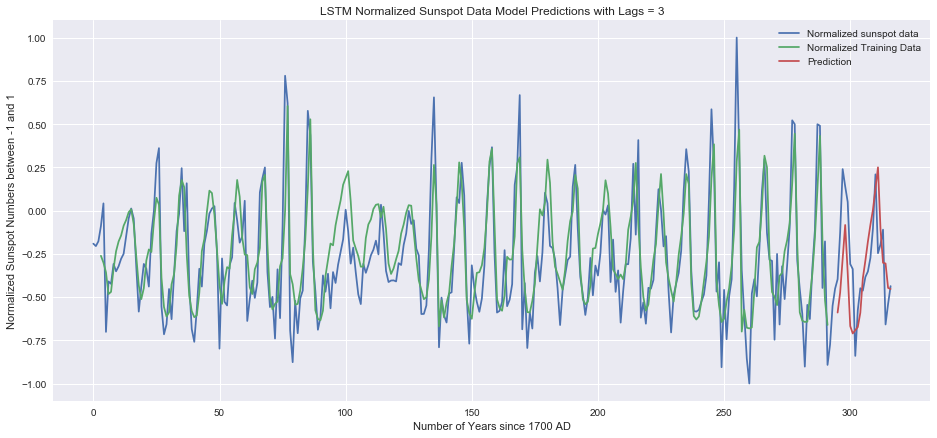

In [101]:
from sklearn.metrics import mean_absolute_error

model.reset_states()
train_predict = model.predict(train_X, batch_size=batch_size)
test_predict = model.predict(test_X, batch_size=batch_size)
test_observed = sunny[-len(test_predict):, :]

print('MAE = ', mean_absolute_error(test_observed, test_predict))

# shift train predictions for plotting
train_predict_plot = np.empty_like(sunny)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(sunny)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_predict):, :] = test_predict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(sunny, label='Normalized sunspot data')
plt.plot(train_predict_plot, label='Normalized Training Data')
plt.plot(test_predict_plot, label='Prediction')
plt.title('LSTM Normalized Sunspot Data Model Predictions with Lags = 3')
plt.ylabel('Normalized Sunspot Numbers between -1 and 1') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.legend()
plt.show()

In [102]:
ISSN_Y_tot # Use *.copy insted !

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1
5,1705.5,96.7,-1.0,-1,1
6,1706.5,48.3,-1.0,-1,1
7,1707.5,33.3,-1.0,-1,1
8,1708.5,16.7,-1.0,-1,1
9,1709.5,13.3,-1.0,-1,1
